# Challenge IMA205 - Report - Doriand Petit

In [1]:
#imports
import cv2
import numpy as np
from time import time
import pandas as pd
import os

#!pip install imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.metrics.pairwise import paired_distances
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline 
np.random.seed(seed=666)

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input,Conv2D, MaxPooling2D,BatchNormalization, LeakyReLU,concatenate
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.keras.__version__)
import functions as f 

2.4.0


## Introduction

As explained on the Kaggle’s websites, the pap smear test is used to detect precancerous and cancerous cells. Our tasks were to classify these cells in 9 groups, as well as decide if each cell was abnormal or not. In order to do this, we had for each cell a RGB image of the cell, as well as masks for their nucleus and their cytoplasm. During my researches, I worked on different algorithms and even different methods (Deep Learning / “Normal” Machine Learning, Pre-computed Features / CNN) to test most of the things we saw in class, and I will thus try to present the different results I found, as well as the evolution of my code.

I will first talk about the features I computed, then the models I used and finally the necessary preprocessing and possible ameliorations of the project.

In [2]:
Working_directory="./ima205challenge2021/"     ### Note : The path should be the path to the directory 
                                               ### that was downloaded on Kaggle (with the same subfolders, as well as the files
                                               ### SampleSubmission and Metadata).
        
Images_train,Y_train,Y_multi_train,Y_multi_train_cat,Images_test,Id_test = f.load(Working_directory)

Shape Image Train :  (2921, 3)
Shape Image Test :  (1252, 3)


# I. The Features

First of all, I am going to write about the features I used across the challenge. The first part of it was dedicated to regular machine learning (without any deep learning), thus I needed to compute my own features from the images. Thanks to the given papers, I was able to determine which features I would need to compute. 


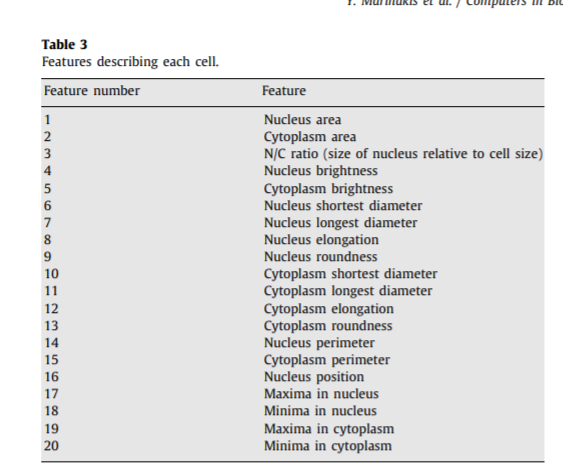


During the first few days of work on the project, I computed more and more of these features while trying some simple models that I will describe in the next part. Finally, I computed all of these features, except the elongation of both the nucleus and the cytoplasm, as I couldn’t seem to find a good way to obtain them. I also choosed to exclude the nucleus position as the results I found were strange and and worsened the results. For the other features, most of them were actually quite easy to compute. The most problematic ones were :

<ul>
    <li> The diameters of the nucleus (Features 6 and 7) : I used the findContours function from the cv2 library on the nucleus mask, and then computed the center of the nucleus from its moments.</li>
        
        M = cv2.moments(contours[k])
        center=[round(M['m10'] / M['m00']),round(M['m01'] / M['m00'])] 
    
</ul>

<ul>
    
<li> The roundness of the nucleus (Feature 9) : I computed the average distance between the nucleus and a circle of diameter the average radius of the nucleus. </li>
    
<li> The same features of the cytoplasm : Because the cytoplasm mask had a hole (the nucleus) in the middle, I did a fusion of the two masks first in order to obtain the shape of the whole cell. Moreover, some of the images had an open cytoplasm, so I had to check that the moments weren't zero and also I had to use the numpy pad function in order to create a border at the edges of the image, as some cytoplasms were on the borders. </li>
    
</ul>
    
        
        

In [3]:
#Careful : The code is not optimised and this function can take a few minutes depending on the computer.

X_train = f.compute_features(Images_train)
X_test = f.compute_features(Images_test)

In order to better understand what the features represent, here are the importance of the features (computed with a GradientBoosting classifier with cross validation, that I will describe in the next part) :

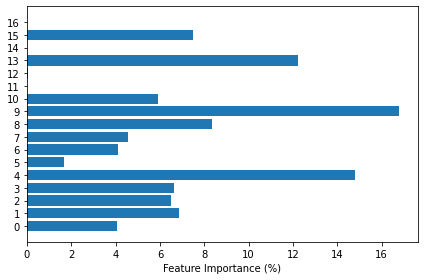

In [4]:
X_train,X_test,Y_train = f.preprocessing(X_train,Y_train,X_test,oversample=True)
model = f.opt_boost_model(X_train,Y_train)
f.feature_importance(model)

As I said earlier, I also tried to use Convolutional Neural Networks on the images to compute its own features. However, a problem of CNNs is that they are quite complicated to interpret and explain. We've seen in practical works the use of the Deep Dream algorithm in order to try understand the features of the neural network. The objective of this algorithm is to modify the input image to maximize the activations of specific layers using gradient ascent. Deep Dream over-interprets and emphasize the models seen in the input image. At first, I thought that I could try to understand the features thanks to this algorithm. However, it did not really work, and the general results of Deep Dream anyway rarely give interpretable results.

# II. Different Models and Algorithms

After computing some of the features, my first step was to create a simple model in order to have my first results. I began with a simple K-Nearest-Neighbor Classifier without even any cross validation. I obtained a very bad result (0.39), which was worse than a random classifier, but that was to be expected. I was literally using only one feature : the nuclear size over cell size ratio. Then I gradually increased the number of features as well as improved the model with cross validation. With 5 features and a simple use of GridSearchCV, I obtained a score of 0.7. Still adding more features as well as some Normalization preprocessing (that I will detail in the next part) brought me to 0.78.  This was when I felt that I needed to try other (and better) classifiers.

In [5]:
Y_test,model = f.models_opt("knn",X_train,Y_train,X_test)
print("Best Parameters : ",model.best_params_)

Best Parameters :  {'algorithm': 'auto', 'n_neighbors': 6, 'weights': 'distance'}


After some research, I decided on the GradientBoostingClassifier. A simple cross validation gave a score of 0.83. Finally I coded all the features and the task was now to have an optimal classifier. During my different tests, my scores varied from 0.85 to 0.873 depending on the cross validation, which was actually quite good. This was at this moment that I submitted my first solution for the multiclass problem. Indeed, the GradientBoostingClassifier also works on multiclass classification. Hence, I applied the same method used for the binary class, and I obtained a score of 0.60. At first, I thought that this score was really bad, but the multiclass problem is way more difficult to solve than the binary one. 

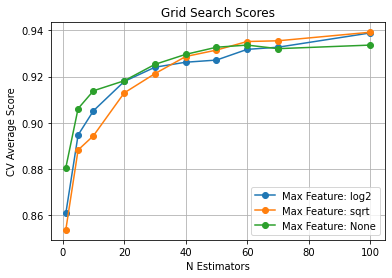

In [6]:
f.gridcv_boosting(X_train,Y_train)

I also quickly tested the random forest algorithm but the results were closer to 0.80, hence I decided to stay with the GradientBoosting classifier. Finally, I came to the conclusion that, with these features, I couldn’t have a much better model across the classical algorithms. I then decided to switch to Deep Learning methods.   


In [4]:
Y_test,model = f.models_opt("random_forest",X_train,Y_train,X_test)
print("Best Parameters : ",model.best_params_)

Best Parameters :  {'n_estimators': 1000}


#### Deep Learning Methods

My first model was a very simple convolutional neural network. The input was only the original images in grayscale. Here is the architecture I went for :


In [7]:
first_cnn = f.first_cnn()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      544       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
flatten (Flatten)            (None, 80000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                5

While the computational time was quite short, the results were not really good, with scores between 0.58 and 0.69 depending on the epochs and the hyperparameters. That was really to be expected as the model is really simple and as we only use the input images without any masks and computed features.

Later on, in order to obtain better scores, I did a complete U-turn and abandoned the CNNs for a while. I wanted to try to combine my already computed features with a multi-layer perceptron, as I was thinking that the results could be quite good. I tried different architectures for this idea, all quite similar but with different hyperparameters and more importantly by trying to add some BatchNormalization layers as well as some DropOut layers.


In [8]:
mlp = f.ann(X_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               2304      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)              

The results were not bad at all going from 0.8 to 0.83 in the binary class problem and from 0.58 to 0.63 in the multiclass problem. However, while these were better than the gradient boosting for the multiclass classification, this was not the case for the binary class one. Moreover, at the time, it was a bit difficult to see how this model could be upgraded. As I said before, I can now see that the model could indeed be much better simply by passing a bit more time on hyperparameters tuning and by adding the last few features. While all these neural networks were not so bad, I was still struggling to better my scores, and time was ticking. Because there was only a few days left before the Kaggle deadline, I decided to once again change my model to a more complex one. My objective was to have a neural network that could have as input, the original images, the masks and even maybe the computed features. 

My first try was to combine the masks and the images as channels of the same “image” in the input of a Convolutional Neural Network. I was hoping for really good results, but on the contrary,I obtained disappointing scores (less than 0.6 for both classification problems) for very long periods of training. As usual, I can now say that I should have passed more time on the model as I think that, at the very least, the results shouldn’t be worse than the first CNN I used (with only the original images as input). But I had only one day left before the deadline and I thus decided to test the last model.

I wanted to have a model that used as input our images (with their masks) and, at the same time the computed features for (or so I hoped) a maximum efficiency. After doing some research on how to have different shapes of input in a neural network, I have found that the concatenate layer could permit assemble the different inputs and after some testing, I went for this architecture, which was quite complicated, but at the same time, relatively easy to understand.

<img src="finalmodel.PNG" alt="drawing" width="400"/>

(If the image isn't loading, here is a link to it : https://drive.google.com/file/d/1UoNXFWE5RNa98g-h-FGLfiz4GgLro8ZQ/view?usp=sharing)

Note : In reality, I used more Conv2D layers in order to reduce the number of parameters.

I could have also gone for two inputs (the features and the images + masks in one “image”) rather than four, but it seems to me that because of the concatenation, the two architectures are equivalent anyway. Unfortunately, the model being more complex (with more inputs), the training was rather long and the hyperparameters tuning was too as there were quite a lot of layers (for instance, I added more 2d convolution layers than usual to reduce the size of the data after the concatenate layer). Hence, I didn’t have much time to do complete training and hyperparameters tuning but even with very imprecise settings and lots of approximation, I obtained scores that were equivalent to my previous best scores. With a better tuning and a better computer (or just more time) to do less approximations (less convolution and most importantly less image size reduction, as I will explain in the preprocessing part), I’m quite sure that the results would be way better. 


In [9]:
X_train_3 = f.compute_features(Images_train)
X_test_3 = f.compute_features(Images_test)
X_train_3,X_test_3,Y_train_3 = f.preprocessing(X_train_3,Y_train,X_test_3,oversample=False)
_,Y_train_3,_,_,_,_ = f.load(Working_directory)
X_train_0,X_train_1,X_train_2,X_test_0,X_test_1,X_test_2 = f.X_train_images(Images_train,Images_test,option=2)

#Careful, might take a few minutes
model = f.final_model(X_train_0,X_train_1,X_train_2,X_train_3,Y_train_3)
Y_test = model.predict([X_test_0,X_test_1,X_test_2,np.array(X_test_3)])
print(Y_test)
#The results may oviously be bad, as there are only two epochs

Shape Image Train :  (2921, 3)
Shape Image Test :  (1252, 3)


C:\Users\DORIA\Documents\CHALLENGE\functions.py:221: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_train = np.array(Images_train)[:]
C:\Users\DORIA\Documents\CHALLENGE\functions.py:222: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_test = np.array(Images_test)[:]


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 100, 100, 32) 320         input_1[0][0]                    
______________________________________________________________________________________________

Epoch 1/2
92/92 [==============================] - 63s 668ms/step - loss: 1.0633 - accuracy: 0.6917
Epoch 2/2
92/92 [==============================] - 61s 667ms/step - loss: 0.6033 - accuracy: 0.7375
[[0.5928813 ]
 [0.98113096]
 [0.3287352 ]
 ...
 [0.38310263]
 [0.5860708 ]
 [0.00945404]]


# III. Some Pre-Processings and Possible Ameliorations

The first preprocessing I used was clearly the most well-known thing to begin with when trying to resolve a classification problem : normalization. After analyzing a bit all the features, I noticed that every feature was positive. Hence, I decided to use the MinMaxScaler() rather than StandardScaler() in order to scale my data. Like I said earlier, I then noticed a small score increase. But, we’ve seen in practical works that it is always a good idea to scale your features whether it increases the score or not.

A common issue in classification problems is the question of class proportion. Indeed, whether we are talking about the binary classes challenge or the 9 classes one, it is important to have balanced classes to not introduce any bias towards one particular class. In order to do this, I used the imbalanced-learn library like we saw in practical works. 

In the binary classification problem, the classes were distributed with **45%** of the cells being class 0 and **55%** being class 1. Even though the proportions were not that different, it is still important to do some random oversampling (we could also do some undersampling). However, quite surprisingly the results were not really different. 

The multiclass classification problem had classes way less balanced. Here is a chart of the initial repartition (of the training set). 


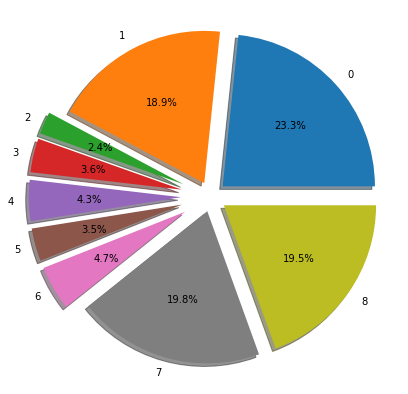

In [10]:
f.plot_pie(Y_multi_train)

However, once again, the results were surprisingly not that better. An important issue of the oversampling method is that it will add way more input images (the number of samples went from **2921 to 6138**), and will thus greatly increase the computational time. On the contrary, using undersampling will remove some images, and the results risk being worse than they should be. I tried anyway to use the oversampling before most if not all my algorithms. 


During some training of my first neuron networks, I had proof of clear overfitting. While the most important changes made to avoid this problem were changes of hyperparameters and of models, I also looked for preprocessing methods to reduce this phenomenon. A common idea is to use an ImageDataGenerator from the keras preprocessing library. This function creates more input images from the original ones by applying translations, zooms, rotations and every other possible geometric transformation. 

However, in an even worse way than the previous preprocessing, the scores became even lower than without the ImageDataGenerator function. After a bit of thinking, the reason was quite obvious : while a simple task of object determination should be able to find this object even though it is not complete ; our algorithms need the whole image to perform the task of cell classification. Also, because the algorithm uses things like the size of the cells,... ; deforming the images will falsen the results.

While looking for other preprocessing methods to reduce overfitting, I found some rather similar processes, such as methods that would merge two images of the dataset with different opacities. However, for the same obvious reasons, I didn’t even try these techniques. 

<img src="datagenerator.webp" alt="drawing" width="400"/>


Finally there was one last preprocessing method I used for every neural network using the images as input. Because the input shape of all my networks needed to be the same for each image, I used the function cv2.resize in order to resize them, as well as the masks if used. By looking at the average size, I first decided to resize all the images to 200x200 dimensions. However, while this size seemed to be quite good in terms of scoring, for the simpler models (those only using the images without masks) ; for more complex models (using at least 3 channels), having these kind of sizes was way too difficult for my computer and I quickly turned down the dimensions to 100x100 once my computer froze for 5 minutes just to display the beginning of the first epoch loading.


### Possible Ameliorations :

It might be important to note that during this project, I have not made any effort on optimization. As long as the code was compiling correctly and my computer wasn’t crashing, I didn’t try to optimize my methods and models. I think that working on this subject could be a really interesting and important thing to do if the objective was to make a real program out of this project. There are lots of issues to solve about it whether in the compute_features function or directly in the neural networks, where I sometimes obtained several millions parameters to train.

Obviously, if the objective was to continue this project, the most important thing to do would be to increase the scores to have the best possible algorithm. As I said earlier, I personally think that my three best models (Gradient Boosting, ANN and concatenated CNNs/ANN) have, in their general idea, the potential to be efficient and can bring really good scores (especially the neural networks) with some small tweaking. Most of all, in order to obtain better scores, the important thing to do would be to pass way more time on hyperparameters tuning. Due to a certain lack of time and most of all, a desire to test as many techniques and kinds of model as possible, I was way too quick in my models’ tuning. This includes hyperparameters tuning (min_samples_split, max_depth, etc… on Gradient Boosting) ; and, more importantly, Neural Networks tuning (number of neurons on each dense layer, …) and the Neural Networks  precise architecture (how many hidden layers, and how many 2D Convolution). If I take the time to do a performance optimization on the previously described final model, or even on the simpler MLP which uses the computed features, I am fairly certain that the scores will be way better than what I obtained on Kaggle. Also, I would certainly need to compute the last features I previously didn’t do and maybe try to find some new features to code from the literature.


## Conclusion

Writing this report left me really frustrated on how this challenge went. I’ve spent quite a lot of time on it, to make easy errors on the last parts of my models which made me obtain bad scores. However, I’ve come to understand these errors and this challenge made me understand a lot of blurry concepts we’ve seen during classes, and I am sure that my results will be much better the next time I participate in this kind of problem solving. Despite these issues, I really appreciated the challenge and I actually look forward to participating in other ones when I will have more free time !

#### Other Functions used during the challenge but not in the report :

In [11]:
#Y_test = convert_Y_test(Y_test,Id_test,problem="binary")  #converts the probability list obtained into the true Y_test
#create_sol(Y_test,problem="binary",title="Submission.csv") #creates the csv submission file from the prediction.